In [1]:
# from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


In [2]:
def k_means(image, ks,iteracion=10):
        
    # Inicialización de valores k
    k_values = np.linspace(np.amin(image), np.amax(image), ks)
    # iteracion=10
    for i in range(iteracion):
        d_values = [np.abs(k - image) for k in k_values]
        segmentationr = np.argmin(d_values, axis=0)

        for k_idx in range(ks):
            k_values[k_idx] = np.mean(image[segmentationr == k_idx])

    return segmentationr

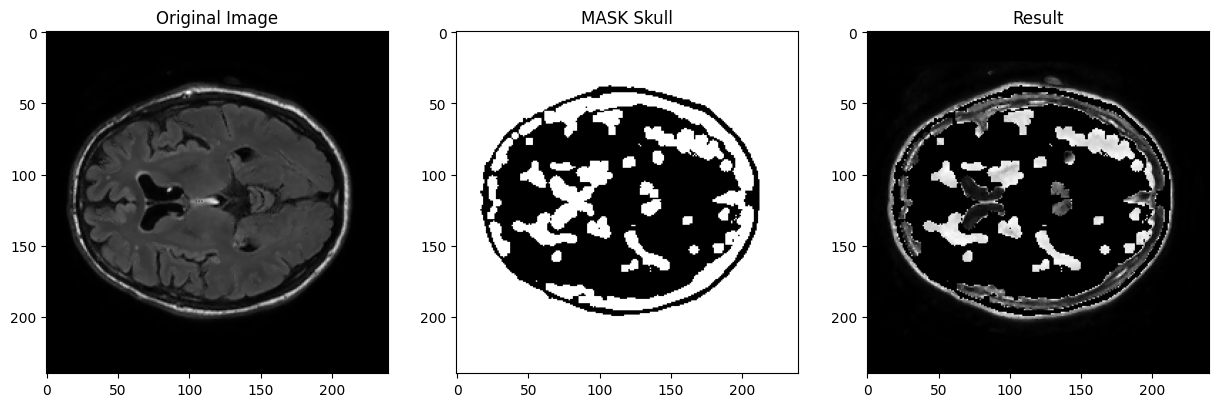

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from sklearn.cluster import KMeans
import nibabel as nib

def k_means(image, ks,iteracion=10):
    # Inicialización de valores k
    k_values = np.linspace(np.amin(image), np.amax(image), ks)
    # iteracion=10
    for i in range(iteracion):
        d_values = [np.abs(k - image) for k in k_values]
        segmentation = np.argmin(d_values, axis=0)

        for k_idx in range(ks):
            k_values[k_idx] = np.mean(image[segmentation == k_idx])
    return segmentation

def remove_skull(image, k_values, segmentation):
    # Identificar los 3 clusters con las intensidades más altas
    max_k_indices = np.argpartition(k_values, -3)[-3:]
    
    # Crear una máscara donde los clusters de mayor intensidad son removidos
    mask = np.isin(segmentation, max_k_indices, invert=True)
    
    # Aplicar la máscara a la imagen
    image_without_skull = image * mask
    
    return image_without_skull

# Leer la imagen
image_data_FLAIR_Registrada = nib.load("../../temp_images/FLAIR.nii.gz").get_fdata()

# Realizar la segmentación
segmentation = k_means(image_data_FLAIR_Registrada, 8)

# Obtener la lista de valores k (intensidades) después de realizar K-means
k_values = [np.mean(image_data_FLAIR_Registrada[segmentation == k]) for k in range(8)]

# Remover el cráneo
image_without_skull = remove_skull(image_data_FLAIR_Registrada, k_values, segmentation)

# Aplicar umbral
image_without_skull = np.where(image_without_skull > np.percentile(image_without_skull, 90), 0, 1)

# Morfología - abrir para remover ruido
image_without_skull = morphology.opening(image_without_skull, morphology.ball(3))

# Aplicar la máscara a la imagen de FLAIR para remover el cráneo
result = image_data_FLAIR_Registrada * image_without_skull

# Mostrar la imagen original y la imagen sin cráneo
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image_data_FLAIR_Registrada[:,:,20], cmap='gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(image_without_skull[:,:,20], cmap='gray')
plt.title('MASK Skull')
plt.subplot(1,3,3)
plt.imshow(result[:,:,20], cmap='gray')
plt.title('Result')
plt.show()


In [4]:
import numpy as np
import nibabel as nib

def extract_brain_without_skull(image_path, skull_mask_path):
    # Load the image using nibabel
    image = nib.load(image_path)

    # Get the image data
    image_data = image.get_fdata()

    # Load the skull mask using nibabel
    skull_mask = nib.load(skull_mask_path).get_fdata()

    # Invert the skull mask to obtain the brain mask
    brain_mask = np.logical_not(skull_mask)

    # Apply the brain mask to the image data
    brain_extracted = image_data.copy()
    brain_extracted[~brain_mask] = 0

    # Create a new nibabel image with the extracted brain
    brain_extracted_image = nib.Nifti1Image(brain_extracted, affine=image.affine)

    # Save the image with the extracted brain to a new file
    nib.save(brain_extracted_image, 'FLAIR_brain_without_skull.nii.gz')

# # Example usage
# image_path = 'Seg_T1.nii.gz'  # Image with the full brain including skull
# skull_mask_path = 'skull_IR.nii.gz'  # Skull mask obtained from the previous method
# extract_brain_without_skull(image_path, skull_mask_path)

[0 1]


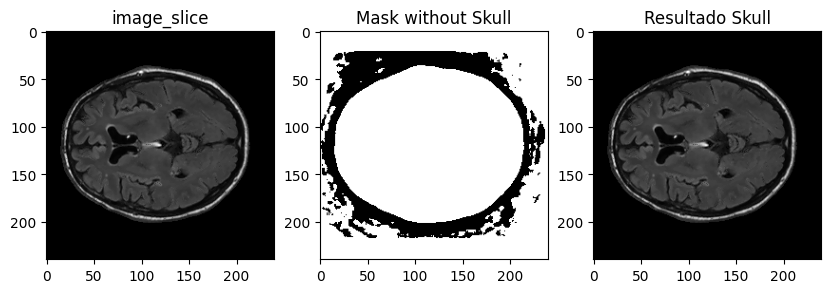

In [9]:
from skimage import morphology, measure
import numpy as np

# Elegir una rebanada específica
slice_idx = 20
image_slice = image_data_FLAIR_Registrada[:,:,slice_idx]

# Umbralización
thresh = np.mean(image_slice)  # Este valor puede necesitar ajustes
binary = image_slice > thresh

# Realizar una operación de cierre para conectar las regiones de tejido cerebral
selem = morphology.disk(10)  # Este valor puede necesitar ajustes
closed = morphology.closing(binary, selem)

# Etiquetar las regiones
labels = measure.label(closed)

# El cráneo y el fondo deberían ser la región más grande
# Así que encuentre la región más grande
largest_region = np.argmax([r.area for r in measure.regionprops(labels)]) + 1

# Crear una máscara con solo la región más grande
mask = labels == largest_region

# Finalmente, multiplicar por la máscara para eliminar el cráneo
image_without_skull = image_slice * ~mask

image_without_skull = np.where(image_without_skull > 0, 0, 1)

unique, counts = np.unique(image_without_skull.astype(np.int32), return_counts=True)
print(unique)

# Apply the mask to the FLAIR image to remove skull
result = np.multiply(image_slice, image_without_skull)


# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(result, cmap='gray')
plt.title('image_slice')
plt.subplot(1,3,2)
plt.imshow(image_without_skull, cmap='gray')
plt.title('Mask without Skull')
plt.subplot(1,3,3)
plt.imshow(result, cmap='gray')
plt.title('Resultado Skull')
plt.show()
